In [49]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms import EstimationProblem
from qiskit.primitives import Sampler
from qiskit_algorithms import AmplitudeEstimation, IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation, FasterAmplitudeEstimation

import matplotlib.pyplot as plt
import pandas as pd

from qiskit import transpile

In [50]:


# Function to convert numbers to ordinal (e.g., 1 -> 1st, 2 -> 2nd, 3 -> 3rd)
def ordinal(n):
    if 10 <= n % 100 <= 20:  # Handles special cases like 11th, 12th, 13th
        suffix = "th"
    else:
        suffix = {1: "st", 2: "nd", 3: "rd"}.get(n % 10, "th")
    return f"{n}{suffix}"


In [51]:
_dpi = 800

In [52]:
# Experiment Setup
p = 0.2

In [53]:
class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


In [54]:
class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [55]:
A = BernoulliA(p)
Q = BernoulliQ(p)

# Canonical AE


In [56]:
problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [57]:
sampler = Sampler()

In [58]:
#  QAE implementation by Brassard et al. 
ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

ae_result = ae.estimate(problem)

In [59]:
print(ae_result.estimation)
print(ae_result.mle)

0.1464466
0.19999999406856905


In [60]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="clifford"
).savefig(f"../circuits/cae.png", dpi=_dpi,bbox_inches='tight')

In [61]:
basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
ae_circuit_transpiled = transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2)
ae_circuit_transpiled.draw("mpl", style="clifford").savefig(f"../circuits/cae_transpiled.png", dpi=_dpi,bbox_inches='tight')

# Iterative Amplitude Estimation

In [62]:
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.2


In [63]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="clifford").savefig(f"../circuits/iae.png", dpi=_dpi,bbox_inches='tight')

# Maximum Likelihood Amplitude Estimation

In [64]:
mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


In [65]:
mlae_circuit = mlae.construct_circuits(problem) # creates a list of 4 circuits, one for each of the evaluation schedules

for i, circuit in enumerate(mlae_circuit):
    circuit.draw("mpl", style="clifford").savefig(f"../circuits/mlae_circuit_{i}.png", dpi=_dpi,bbox_inches='tight')

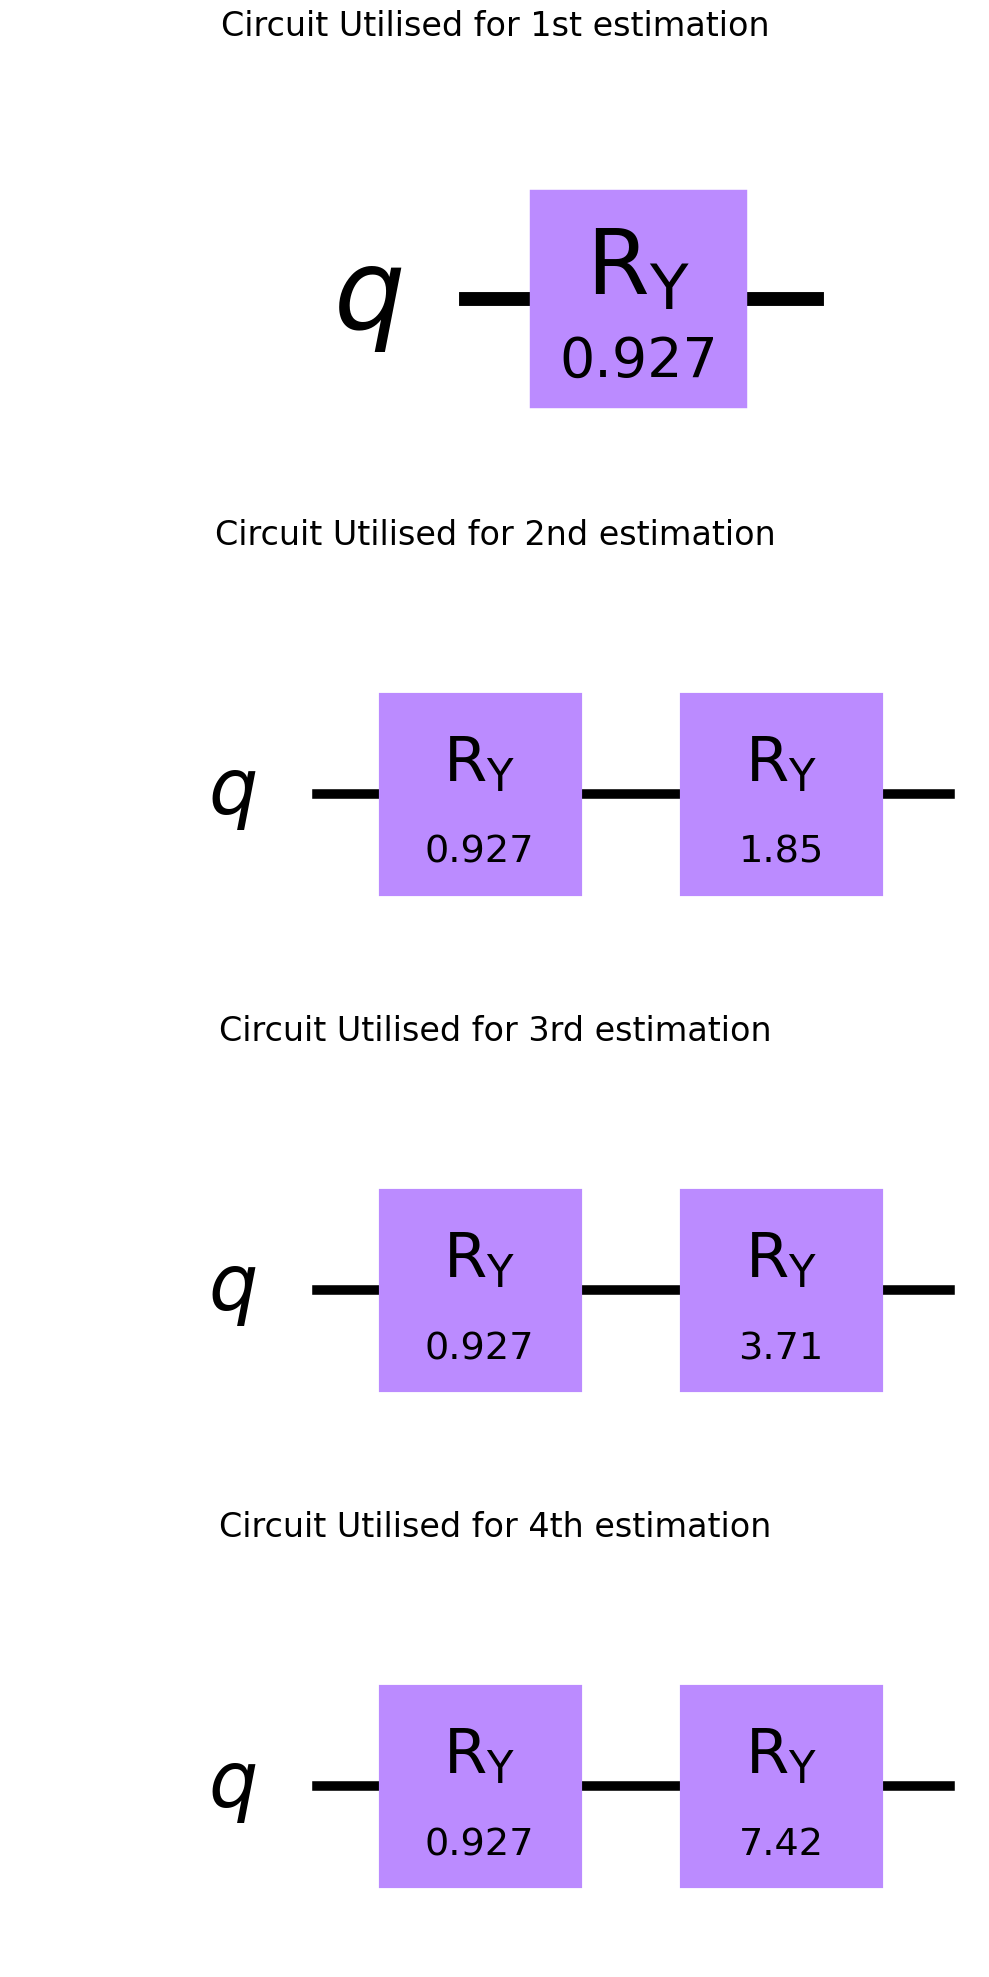

In [66]:
# Number of circuits
num_circuits = len(mlae_circuit)

# Create subplots (adjust rows and columns as needed)
fig, axes = plt.subplots(nrows=num_circuits, ncols=1, figsize=(10, 5 * num_circuits))

# Ensure axes is iterable even for one circuit
if num_circuits == 1:
    axes = [axes]

# Draw each circuit on a subplot
for i, (ax, circuit) in enumerate(zip(axes, mlae_circuit)):
    circuit.draw("mpl", style="clifford", ax=ax)
    ax.set_title(f"Circuit Utilised for {ordinal(i+1)} estimation", fontsize=24)  # Set label for each subplot

# Adjust layout
plt.tight_layout()

# Save the combined image
plt.savefig("../circuits/combined_mlae_circuits.png", dpi=_dpi)

# Faster Amplitude Estimation

In [67]:
fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.19847529527324675


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_algorithms/amplitude_estimators/estimation_problem.py:214: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


In [68]:
fae_circuit = fae.construct_circuit(problem, k =3)
fae_circuit.draw("mpl", style="clifford").savefig(f"../circuits/fae.png", dpi=_dpi,bbox_inches='tight')

In [69]:
results = {
    "Canonical AE" : (ae_circuit_transpiled, ae_result.estimation),
    "Canonical AE MLE" : (ae_circuit_transpiled, ae_result.mle),
    "Iterative Amplitude Estimation": (iae_circuit, iae_result.estimation),
    "Maximum Likelihood Amplitude Estimation": (mlae_circuit, mlae_result.estimation),
    "Faster Amplitude Estimation": (fae_circuit, fae_result.estimation)  
}

In [70]:
def abs_error(m1,m2):
    return abs(m1 - m2)

def relative_error(m1,m2):
    return abs_error(m1,m2)/abs(m1)

def mse(m1,m2):
    return (m2 - m1) ** 2

In [71]:
def circuits_to_dataframe(circuits_dict):
    data = []
    
    for name, data_circuit in circuits_dict.items():
        qc = data_circuit[0]
        if not isinstance(qc, list):
            num_qubits = qc.num_qubits
            num_clbits = qc.num_clbits
            depth = qc.depth()
            samples = qc.depth()
        else:
            num_qubits = 0
            num_clbits = 0
            depth_list = []
            samples = len(qc)
            for circuit in qc:
                num_qubits += circuit.num_qubits
                num_clbits += circuit.num_clbits
                depth_list.append(circuit.depth())
                
            depth = max(depth_list)
                
            
        
        result = data_circuit[1]
        
        print(p, result)

        
        # Store all data in a row
        row = {"Circuit Name": name, "Samples": samples,"Qubits": num_qubits, "Classical Bits": num_clbits, "Depth": depth, "Estimated Value": result, 'Absolute Error': abs_error(p, result), 'Relative Error': relative_error(p, result), 'MSE': mse(p, result)}
        data.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    return df

In [72]:
df = circuits_to_dataframe(results)

# Display DataFrame
print(df)
df_latex = df[["Circuit Name","Absolute Error", "Relative Error" ,"MSE"]].copy()
df_circuit = df[["Circuit Name", "Samples", "Qubits", "Classical Bits", "Depth", "Estimated Value"]]
for column in ["Absolute Error", "Relative Error" ,"MSE"]:
    df_latex[column] = df[column].map(lambda x: f"{x:.6e}")
df_circuit["Estimated Value"] = df["Estimated Value"].map(lambda x: f"{x:.10f}")
print(df_latex.to_latex(index=False))

print("\n")

print(df_circuit.to_latex(index=False))

0.2 0.1464466
0.2 0.19999999406856905
0.2 0.2
0.2 0.20002237175368104
0.2 0.19847529527324675
                              Circuit Name  Samples  Qubits  Classical Bits  \
0                             Canonical AE       62       4               0   
1                         Canonical AE MLE       62       4               0   
2           Iterative Amplitude Estimation        2       1               0   
3  Maximum Likelihood Amplitude Estimation        4       4               0   
4              Faster Amplitude Estimation        2       1               0   

   Depth  Estimated Value  Absolute Error  Relative Error           MSE  
0     62         0.146447    5.355340e-02    2.677670e-01  2.867967e-03  
1     62         0.200000    5.931431e-09    2.965715e-08  3.518187e-17  
2      2         0.200000    0.000000e+00    0.000000e+00  0.000000e+00  
3      2         0.200022    2.237175e-05    1.118588e-04  5.004954e-10  
4      2         0.198475    1.524705e-03    7.623524e-03  2.

/var/folders/cn/b5bxb_yn5f92sbwfyz27x1sc0000gn/T/ipykernel_33178/3633357046.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_circuit["Estimated Value"] = df["Estimated Value"].map(lambda x: f"{x:.10f}")
